# Imports

In [186]:
import copy
import csv
import datetime
import gzip
import io
import os
import re
import string
import time
from collections import Counter
from math import pi

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import praw
import requests
import seaborn as sns
import spacy
from IPython.display import FileLink, IFrame
from better_profanity import profanity
from colorama import Fore, Style, init
from fuzzywuzzy import fuzz, process
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from nltk import word_tokenize, stem
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from plotly import express as px, graph_objects as go, io as pio
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image
from scipy.spatial import distance
from scipy.stats import (zscore, ttest_1samp, f_oneway, ttest_rel, stats)
from sklearn.cluster import (AgglomerativeClustering, KMeans, AffinityPropagation)
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from pandas.plotting import parallel_coordinates

In [187]:
lemmatizer = WordNetLemmatizer()
stemmer = stem.PorterStemmer()
stop_words = set(stopwords.words('english'))
nltk.download('stopwords')
punct = list(string.punctuation)
punctuations = string.punctuation
nltk.download('punkt')
nltk.download('wordnet')
cudnn.benchmark = True

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louisvsbigmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/louisvsbigmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/louisvsbigmac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [188]:
#Find files in repo
vad = pd.read_excel('/Users/louisvsbigmac/Documents/Office 365/xlsx/vad.xlsx', index_col = 0)
sn = pd.read_csv('/Users/louisvsbigmac/Documents/Office 365/xlsx/sensorimotor_norms_complete.csv', index_col = 0)
cc = pd.read_excel('/Users/louisvsbigmac/Documents/Office 365/xlsx/Creative Careers.xlsx', index_col=0)
file_path = '/Users/louisvsbigmac/Documents/Office 365/xlsx/Creative Careers.xlsx' 
spreadsheet = pd.ExcelFile(file_path)
df = spreadsheet.parse('Sheet1')

# NLP Code

In [189]:
sn_column_means = sn.mean()
sn_mean_df = pd.DataFrame({'Mean_Value': sn_column_means})
vad_column_means = vad.mean()
vad_mean_df = pd.DataFrame({'Mean_Value': vad_column_means})
cc['Word_Count'] = cc['Description'].apply(lambda x: len(str(x).split()))
word_count_stats = cc['Word_Count'].describe()
word_count_stats_df = word_count_stats.to_frame(name='Word Count Statistics')

In [190]:
#plt.subplot(1, 2, 2)
#plt.boxplot(cc['Word_Count'], vert=False)
#plt.xlabel('Number of Words')
#plt.title('Boxplot of Word Counts in Job Descriptions')
#plt.tight_layout()
#plt.show()

In [191]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

def remove_punctuation(tokens):
    punctuations = string.punctuation
    filtered_tokens = [token for token in tokens if token not in punctuations]
    return filtered_tokens

In [192]:
cc['Edited_Description'] = cc['Description'].astype(str)
cc['Edited_Description'] = cc['Edited_Description'].apply(tokenize_text)
cc['Edited_Description'] = cc['Edited_Description'].apply(lemmatize_text)
cc['Edited_Description'] = cc['Edited_Description'].apply(remove_stopwords)
cc['Edited_Description'] = cc['Edited_Description'].apply(remove_punctuation)
cc['Edited_Description'] = cc['Edited_Description'].apply(lambda x: [word.lower() for word in x])

In [193]:
def calculate_average_vad(tokens):
    valence_scores = []
    arousal_scores = []
    dominance_scores = []

    for word in tokens:
        if word in vad.index:
            valence_scores.append(vad.loc[word, 'valence'])
            arousal_scores.append(vad.loc[word, 'arousal'])
            dominance_scores.append(vad.loc[word, 'dominance'])

    avg_valence = sum(valence_scores) / len(valence_scores) if valence_scores else None
    avg_arousal = sum(arousal_scores) / len(arousal_scores) if arousal_scores else None
    avg_dominance = sum(dominance_scores) / len(dominance_scores) if dominance_scores else None

    return avg_valence, avg_arousal, avg_dominance

cc['Valence'], cc['Arousal'], cc['Dominance'] = zip(*cc['Edited_Description'].apply(calculate_average_vad))

In [194]:
sn.reset_index(inplace=True)
sn.rename(columns={'index': 'Word'}, inplace=True)
sn['Word'] = sn['Word'].str.lower()
sn.set_index('Word', inplace=True)
cc.reset_index(inplace=True)

In [195]:
def preprocess_description_simple(description):
    if isinstance(description, list):
        description = ' '.join(description)
    tokens = re.findall(r'\b\w+\b', description.lower())
    return tokens

def calculate_average_sn(tokens):
    auditory_scores = []
    gustatory_scores = []
    haptic_scores = []
    interoceptive_scores = []
    olfactory_scores = []
    visual_scores = []
    foot_leg_scores = []
    hand_arm_scores = []
    head_scores = []
    mouth_scores = []
    torso_scores = []

    for word in tokens:
        if word in sn.index:
            auditory_scores.append(sn.loc[word, 'Auditory.mean'])
            gustatory_scores.append(sn.loc[word, 'Gustatory.mean'])
            haptic_scores.append(sn.loc[word, 'Haptic.mean'])
            interoceptive_scores.append(sn.loc[word, 'Interoceptive.mean'])
            olfactory_scores.append(sn.loc[word, 'Olfactory.mean'])
            visual_scores.append(sn.loc[word, 'Visual.mean'])
            foot_leg_scores.append(sn.loc[word, 'Foot_leg.mean'])
            hand_arm_scores.append(sn.loc[word, 'Hand_arm.mean'])
            head_scores.append(sn.loc[word, 'Head.mean'])
            mouth_scores.append(sn.loc[word, 'Mouth.mean'])
            torso_scores.append(sn.loc[word, 'Torso.mean'])
    
    avg_auditory = sum(auditory_scores) / len(auditory_scores) if auditory_scores else None
    avg_gustatory = sum(gustatory_scores) / len(gustatory_scores) if gustatory_scores else None
    avg_haptic = sum(haptic_scores) / len(haptic_scores) if haptic_scores else None
    avg_interoceptive = sum(interoceptive_scores) / len(interoceptive_scores) if interoceptive_scores else None
    avg_olfactory = sum(olfactory_scores) / len(olfactory_scores) if olfactory_scores else None
    avg_visual = sum(visual_scores) / len(visual_scores) if visual_scores else None
    avg_foot_leg = sum(foot_leg_scores) / len(foot_leg_scores) if foot_leg_scores else None
    avg_hand_arm = sum(hand_arm_scores) / len(hand_arm_scores) if hand_arm_scores else None
    avg_head = sum(head_scores) / len(head_scores) if head_scores else None
    avg_mouth = sum(mouth_scores) / len(mouth_scores) if mouth_scores else None
    avg_torso = sum(torso_scores) / len(torso_scores) if torso_scores else None
    
    return avg_auditory, avg_gustatory, avg_haptic, avg_interoceptive, avg_olfactory, avg_visual, avg_foot_leg, avg_hand_arm, avg_head, avg_mouth, avg_torso

cc['Auditory'], cc['Gustatory'], cc['Haptic'], cc['Interoceptive'], cc['Olfactory'], cc['Visual'], cc['Foot_leg'], cc['Hand_arm'], cc['Head'], cc['Mouth'], cc['Torso'] = zip(*cc['Edited_Description'].apply(calculate_average_sn))

In [196]:
sensorimotor_columns = [
    'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 
    'Olfactory', 'Visual', 'Foot_leg', 'Hand_arm', 
    'Head', 'Mouth', 'Torso'
]

industry_sensorimotor_means = cc.groupby('Discipline')[sensorimotor_columns].mean()
process_sensorimotor_means = cc.groupby('Process')[sensorimotor_columns].mean()
function_sensorimotor_means = cc.groupby('Function')[sensorimotor_columns].mean()


vad_columns = [
    'Valence', 'Arousal', 'Dominance'
]

industry_vad_means = cc.groupby('Discipline')[vad_columns].mean()
process_vad_means = cc.groupby('Process')[vad_columns].mean()
function_vad_means = cc.groupby('Function')[vad_columns].mean()

In [197]:
analysis_columns = vad_columns + sensorimotor_columns

def perform_anova(data, dependent_var, factor):
    model = ols(f'{dependent_var} ~ C({factor})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

def anova_analysis(data, columns, factors):
    anova_results = {}
    for factor in factors:
        for column in columns:
            anova_results[(column, factor)] = perform_anova(data, column, factor)
    return anova_results

factors = ['Function', 'Process', 'Discipline']
anova_results = anova_analysis(cc, analysis_columns, factors)

#for key, result in anova_results.items():
 #   print(f"ANOVA result for {key[0]} by {key[1]}:")
  #  print(result)
   # print("\n")

def boxplot_visualization(data, columns, factors):
    for factor in factors:
        for column in columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=factor, y=column, data=data)
            plt.title(f'{column} by {factor}')
            plt.xticks(rotation=90)
            plt.show()
#boxplot_visualization(cc, analysis_columns, factors)

In [198]:
vad_sn_features = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 
    'Olfactory', 'Visual', 'Foot_leg', 'Hand_arm', 
    'Head', 'Mouth', 'Torso'
]

cc = cc.drop_duplicates(subset=['Job'], keep='first')

def bootstrap_mean(data, n_bootstraps=1000):
    bootstrapped_means = []
    for _ in range(n_bootstraps):
        boot_sample = data.sample(n=len(data), replace=True)
        bootstrapped_means.append(boot_sample.mean())
    return np.array(bootstrapped_means)

bootstrap_results = {discipline: bootstrap_mean(cc[cc['Process'] == discipline][vad_sn_features]) for discipline in cc['Process'].unique()}
bootstrapped_means = {discipline: np.mean(bootstrap_results[discipline], axis=0) for discipline in bootstrap_results}
bootstrapped_means_df = pd.DataFrame(bootstrapped_means).T
bootstrapped_means_df.columns = vad_sn_features
cosine_similarities = cosine_similarity(bootstrapped_means_df)

#plt.figure(figsize=(12, 10))
#sns.heatmap(cosine_similarities, xticklabels=bootstrapped_means_df.index, yticklabels=bootstrapped_means_df.index, cmap='viridis')
#plt.title('VAD Values Cosine Similarity Heatmap of Processes')
#plt.xlabel('Processes')
#plt.ylabel('Processes')
#plt.show()

In [199]:
required_columns = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 'Olfactory', 
    'Visual', 'Foot_leg', 'Hand_arm', 'Head', 'Mouth', 'Torso'
]

if not all(col in cc.columns for col in required_columns):
    raise ValueError(f"Some required columns are missing from the dataset. Found columns: {cc.columns}")

vad_columns = ['Valence', 'Arousal', 'Dominance']
sensorimotor_columns = [
    'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 'Olfactory', 'Visual', 'Foot_leg', 
    'Hand_arm', 'Head', 'Mouth', 'Torso'
]

vad_means = cc[vad_columns].mean()
vad_stds = cc[vad_columns].std()

sensorimotor_means = cc[sensorimotor_columns].mean()
sensorimotor_stds = cc[sensorimotor_columns].std()

# Function to compute z-score
def compute_z_score(x, mean, std):
    return (x - mean) / std

# Function to categorize z-scores
def categorize_z_score(z):
    if z <= -1.5:
        return 'Extremely Low'
    elif z <= -0.5:
        return 'Low'
    elif z <= 0.5:
        return 'Moderate'
    elif z <= 1.5:
        return 'High'
    else:
        return 'Extremely High'

for col in vad_columns:
    mean = vad_means[col]
    std = vad_stds[col]
    z_scores = cc[col].apply(compute_z_score, args=(mean, std))
    cc[f'{col}_Category'] = z_scores.apply(categorize_z_score)

for col in sensorimotor_columns:
    mean = sensorimotor_means[col]
    std = sensorimotor_stds[col]
    z_scores = cc[col].apply(compute_z_score, args=(mean, std))
    cc[f'{col}_Category'] = z_scores.apply(categorize_z_score)
metrics = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic',
    'Interoceptive', 'Olfactory', 'Visual', 'Foot_leg', 'Hand_arm', 'Head',
    'Mouth', 'Torso'
]

mean_scores_by_discipline = cc.groupby('Function')[metrics].mean()

def compute_z_score(x, mean, std):
    return (x - mean) / std

def categorize_z_score(z):
    if z <= -1.5:
        return 'Extremely Low'
    elif z <= -0.5:
        return 'Low'
    elif z <= 0.5:
        return 'Moderate'
    elif z <= 1.5:
        return 'High'
    else:
        return 'Extremely High'

overall_means = cc[metrics].mean()
overall_stds = cc[metrics].std()

qual_metrics_by_discipline = mean_scores_by_discipline.apply(lambda x: [
    categorize_z_score(compute_z_score(x[metric], overall_means[metric], overall_stds[metric])) for metric in metrics
], axis=1)

qual_metrics_df = pd.DataFrame(qual_metrics_by_discipline.tolist(), index=mean_scores_by_discipline.index, columns=metrics).T
#qual_metrics_df.to_excel("Qualitative_NLP_Stats_by_Discipline_Transposed12.xlsx")


In [200]:
metrics = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic',
    'Interoceptive', 'Olfactory', 'Visual', 'Foot_leg', 'Hand_arm', 'Head',
    'Mouth', 'Torso'
]

mean_scores_by_discipline = cc.groupby('Function')[metrics].mean()

def compute_z_score(x, mean, std):
    return (x - mean) / std

def categorize_z_score(z):
    if z <= -1.5:
        return 'Extremely Low'
    elif z <= -0.5:
        return 'Low'
    elif z <= 0.5:
        return 'Moderate'
    elif z <= 1.5:
        return 'High'
    else:
        return 'Extremely High'

overall_means = cc[metrics].mean()
overall_stds = cc[metrics].std()

qual_metrics_by_discipline = mean_scores_by_discipline.apply(lambda x: [
    categorize_z_score(compute_z_score(x[metric], overall_means[metric], overall_stds[metric])) for metric in metrics
], axis=1)

qual_metrics_df = pd.DataFrame(qual_metrics_by_discipline.tolist(), index=mean_scores_by_discipline.index, columns=metrics).T
#qual_metrics_df.to_excel("Qualitative_NLP_Stats_by_Discipline_Transposed12.xlsx")

In [201]:
#process_job_counts = cc['Function'].value_counts()
#palette = sns.color_palette("husl", len(process_job_counts))
#plt.figure(figsize=(10, 6))
#process_job_counts.plot(kind='bar', color=palette)
#plt.title('Job Counts by Process Category')
#plt.xlabel('Process')
#plt.ylabel('Job Count')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()

In [202]:
cluster_groups = {}
for cluster in pca_df['Cluster'].unique():
    cluster_groups[cluster] = pca_df[pca_df['Cluster'] == cluster]['Job'].tolist()
cluster_groups_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_groups.items()]))
#cluster_groups_df.to_csv('job_description_cluster_groups.csv', index=False)

In [203]:
metrics = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 'Olfactory', 
    'Visual', 'Foot_leg', 'Hand_arm', 'Head', 'Mouth', 'Torso'
]
categories = ['Discipline', 'Function', 'Process']

def calculate_thresholds(data, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    return np.percentile(data, [q * 100 for q in quantiles])

thresholds = {metric: calculate_thresholds(cc[metric]) for metric in metrics}

def categorize_value(value, thresholds):
    if value <= thresholds[0]:
        return 'Extremely Low'
    elif value <= thresholds[1]:
        return 'Low'
    elif value <= thresholds[2]:
        return 'Moderate'
    elif value <= thresholds[3]:
        return 'High'
    else:
        return 'Extremely High'

def create_categorized_df(data, metrics, category, thresholds):
    categorized_data = {}
    for metric in metrics:
        # Calculate mean value for each category
        mean_values = data.groupby(category)[metric].mean()
        # Categorize each mean value based on thresholds
        categorized_data[metric] = mean_values.apply(categorize_value, args=(thresholds[metric],))
    return pd.DataFrame(categorized_data).T

df_discipline = create_categorized_df(cc, metrics, 'Discipline', thresholds)
df_function = create_categorized_df(cc, metrics, 'Function', thresholds)
df_process = create_categorized_df(cc, metrics, 'Process', thresholds)

#df_discipline.to_excel("Categorized_NLP_Stats_by_Discipline_Transposed 1.xlsx")
#df_function.to_excel("Categorized_NLP_Stats_by_Function_Transposed 1.xlsx")
#df_process.to_excel("Categorized_NLP_Stats_by_Process_Transposed 1.xlsx")

#import ace_tools as tools; tools.display_dataframe_to_user(name="Categorized NLP Stats by Discipline", dataframe=df_discipline)
#tools.display_dataframe_to_user(name="Categorized NLP Stats by Function", dataframe=df_function)
#tools.display_dataframe_to_user(name="Categorized NLP Stats by Process", dataframe=df_process)


#print("Categorized NLP Metrics by Discipline:\n", df_discipline)
#print("\nCategorized NLP Metrics by Function:\n", df_function)
#print("\nCategorized NLP Metrics by Process:\n", df_process)

In [204]:
metrics = [
    'Valence', 'Arousal', 'Dominance', 'Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 'Olfactory', 
    'Visual', 'Foot_leg', 'Hand_arm', 'Head', 'Mouth', 'Torso'
]
categories = ['Discipline', 'Function', 'Process']

def calculate_thresholds(data, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    return np.percentile(data, [q * 100 for q in quantiles])

thresholds = {metric: calculate_thresholds(cc[metric]) for metric in metrics}
thresholds_df = pd.DataFrame(thresholds, index=['10th Percentile', '25th Percentile', '50th Percentile', '75th Percentile', '90th Percentile'])
#thresholds_df.to_excel("Thresholds_for_Metrics.xlsx")
#import ace_tools as tools; tools.display_dataframe_to_user(name="Thresholds for Metrics", dataframe=thresholds_df)
#thresholds_df

# Clustering

In [205]:
job_descriptions = cc['Description'] 
vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity
tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_features)

pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['Job'] = cc['Job']
pca_df['Process'] = cc['Process']
pca_df['Function'] = cc['Function']
pca_df['Discipline'] = cc['Discipline']

def determine_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

optimal_clusters = determine_optimal_clusters(pca_df[['PC1', 'PC2', 'PC3']])

kmeans = KMeans(n_clusters=optimal_clusters)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])
pca_df['Cluster'] = clusters

#fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', hover_data=['Job', 'Process', 'Function', 'Discipline'])
#fig.update_traces(marker=dict(size=8, line=dict(width=1, color='black')), selector=dict(mode='markers'))
#fig.update_layout(title='Job Clustering Visualization based on Job Descriptions')
#fig.show()
#fig.write_html('job_clustering_visualization1.html')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

In [206]:
job_descriptions = cc['Description']
job_descriptions = job_descriptions.fillna('')

vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity
tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_features)

pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['Job'] = cc['Job']
pca_df['Process'] = cc['Process']
pca_df['Function'] = cc['Function']
pca_df['Discipline'] = cc['Discipline']
pca_df = pca_df.dropna(subset=['Job', 'Process', 'Function', 'Discipline'])

def determine_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

optimal_clusters = determine_optimal_clusters(pca_df[['PC1', 'PC2', 'PC3']])

kmeans = KMeans(n_clusters=optimal_clusters)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])
pca_df['Cluster'] = clusters

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

In [207]:
job_descriptions = cc['Description']
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_features)

pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['Job'] = cc['Job']
pca_df['Process'] = cc['Process']
pca_df['Function'] = cc['Function']
pca_df['Discipline'] = cc['Discipline']

def determine_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

optimal_clusters = determine_optimal_clusters(pca_df[['PC1', 'PC2', 'PC3']])
kmeans = KMeans(n_clusters=optimal_clusters)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])
pca_df['Cluster'] = clusters
manova = MANOVA.from_formula('PC1 + PC2 + PC3 ~ Cluster', data=pca_df)
manova_results = manova.mv_test()
#print(manova_results)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

In [208]:
job_descriptions = cc['Description']
vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_features)

pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['Job'] = cc['Job']
pca_df['Process'] = cc['Process']
pca_df['Function'] = cc['Function']
pca_df['Discipline'] = cc['Discipline']

def determine_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = np.argmax(silhouette_scores) + 2
    return optimal_clusters

optimal_clusters = determine_optimal_clusters(pca_df[['PC1', 'PC2', 'PC3']])

kmeans = KMeans(n_clusters=optimal_clusters)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])
pca_df['Cluster'] = clusters

cluster_composition = pca_df.groupby('Cluster').agg({
    'Process': lambda x: x.value_counts().idxmax(),
    'Function': lambda x: x.value_counts().idxmax(),
    'Discipline': lambda x: x.value_counts().idxmax()
}).reset_index()

def calculate_homogeneity(df, column):
    from scipy.stats import entropy
    counts = df[column].value_counts()
    return entropy(counts, base=2)

pca_df['Homogeneity_Process'] = pca_df.groupby('Cluster')['Process'].transform(calculate_homogeneity, column='Process')
pca_df['Homogeneity_Function'] = pca_df.groupby('Cluster')['Function'].transform(calculate_homogeneity, column='Function')
pca_df['Homogeneity_Discipline'] = pca_df.groupby('Cluster')['Discipline'].transform(calculate_homogeneity, column='Discipline')

import ace_tools as tools; tools.display_dataframe_to_user(name="Cluster Composition", dataframe=cluster_composition)
import ace_tools as tools; tools.display_dataframe_to_user(name="Cluster Homogeneity", dataframe=pca_df[['Cluster', 'Homogeneity_Process', 'Homogeneity_Function', 'Homogeneity_Discipline']].drop_duplicates())


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

KeyError: 'Process'

# Chatbots

In [212]:
num_jobs = df.shape[0]
jobs_per_discipline = df['Discipline'].value_counts()
#print(f'Total number of jobs: {num_jobs}')
#print('Number of jobs per discipline:')
#print(jobs_per_discipline)

In [214]:
#grouped = df.groupby(['Discipline', 'Process', 'Function'])['Job'].apply(list).reset_index()
#for discipline, discipline_df in grouped.groupby('Discipline'):
 #   print(f"Discipline: {discipline}")
 #   for _, row in discipline_df.iterrows():
 #       process = row['Process']
 #       function = row['Function']
 #       jobs = row['Job']
 #       print(f"  Process: {process}")
 #       print(f"    Function: {function}")
 #       for job in jobs:
 #           print(f"      Job: {job}")
#  print()

In [215]:
custom_offensive_words = [
    'racist', 'idiot', 'stupid', 'dumb', 'moron', 'jerk', 'asshole', 'bastard',
    'dickhead', 'shithead', 'retard', 'loser', 'freak', 'creep', 'scumbag',
    # More offensive words are needed!
]

def contains_profanity(text):
    text = text.lower()
    for word in custom_offensive_words:
        if re.search(r'\b' + re.escape(word) + r'\b', text):
            return True
    return False

keyword_to_job = {
    'wood': ['Carpenter', 'Woodworker', 'Furniture maker'],
    'data': ['Data analyst', 'Data scientist', 'Statistician'],
    'architecture': ['Architect', 'Architectural technologist'],
    'science': ['Scientist', 'Researcher', 'Data scientist', 'Biologist', 'Chemist'],
    'engineering': ['Engineer', 'Mechanical engineer', 'Electrical engineer', 'Civil engineer'],
    # More keyword-to-job mappings are needed!
}

def fuzzy_match(prompt, choices, score_threshold=80):
    matches = process.extract(prompt, choices, limit=10, scorer=fuzz.partial_ratio)
    return [match for match in matches if match[1] >= score_threshold]

def recommend_jobs(prompt, df):
    prompt = prompt.lower()
    
    if contains_profanity(prompt):
        return "The prompt contains offensive language. Please try again with appropriate language."
    
    if prompt in keyword_to_job:
        related_jobs = keyword_to_job[prompt]
        matching_jobs = df[df['Job'].str.lower().isin([job.lower() for job in related_jobs])]
        if not matching_jobs.empty:
            return matching_jobs[['Discipline', 'Process', 'Function', 'Job']]
    
    disciplines = df['Discipline'].str.lower().unique()
    functions = df['Function'].str.lower().unique()
    processes = df['Process'].str.lower().unique()
    jobs = df['Job'].str.lower().unique()
    
    matching_disciplines = fuzzy_match(prompt, disciplines)
    matching_functions = fuzzy_match(prompt, functions)
    matching_processes = fuzzy_match(prompt, processes)
    matching_jobs = fuzzy_match(prompt, jobs)
    
    matches = set()
    for match in matching_disciplines:
        matches.update(df[df['Discipline'].str.lower() == match[0]].index)
    for match in matching_functions:
        matches.update(df[df['Function'].str.lower() == match[0]].index)
    for match in matching_processes:
        matches.update(df[df['Process'].str.lower() == match[0]].index)
    for match in matching_jobs:
        matches.update(df[df['Job'].str.lower() == match[0]].index)
    
    if not matches:
        return f"No jobs found matching the prompt: {prompt}"
    
    matching_jobs = df.loc[list(matches), ['Discipline', 'Process', 'Function', 'Job']]
    return matching_jobs

def main():
    print(Fore.CYAN + "Welcome to the Job Recommendation App!" + Style.RESET_ALL)
    print("Enter a prompt to find appropriate jobs (e.g., 'Manager', 'Technologist'): ")
    
    while True:
        prompt = input(Fore.YELLOW + "Enter your prompt (or 'exit' to quit): " + Style.RESET_ALL)
        if prompt.lower() == 'exit':
            print(Fore.CYAN + "Thank you for using the Job Recommendation App. Goodbye!" + Style.RESET_ALL)
            break
        
        recommendations = recommend_jobs(prompt, df)
        
        print(Fore.GREEN + "\nRecommended Jobs:" + Style.RESET_ALL)
        if isinstance(recommendations, str):
            print(Fore.RED + recommendations + Style.RESET_ALL)
        else:
            for _, row in recommendations.iterrows():
                print(Fore.BLUE + f"Discipline: {row['Discipline']}" + Style.RESET_ALL)
                print(Fore.MAGENTA + f"  Process: {row['Process']}" + Style.RESET_ALL)
                print(Fore.YELLOW + f"    Function: {row['Function']}" + Style.RESET_ALL)
                print(Fore.CYAN + f"      Job: {row['Job']}" + Style.RESET_ALL)
                print(Fore.WHITE + "-"*40 + Style.RESET_ALL)  # Separator for better readability

if __name__ == "__main__":
    file_path = '/Users/louisvsbigmac/Documents/Office 365/xlsx/Creative Careers.xlsx' 
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    main()


Welcome to the Job Recommendation App!
Enter a prompt to find appropriate jobs (e.g., 'Manager', 'Technologist'): 
Enter your prompt (or 'exit' to quit): exit
Thank you for using the Job Recommendation App. Goodbye!


In [216]:
custom_offensive_words = [
    'racist', 'idiot', 'stupid', 'dumb', 'moron', 'jerk', 'asshole', 'bastard',
    'dickhead', 'shithead', 'retard', 'loser', 'freak', 'creep', 'scumbag',
    # More offensive words are needed!
]

def contains_profanity(text):
    text = text.lower()
    for word in custom_offensive_words:
        if re.search(r'\b' + re.escape(word) + r'\b', text):
            return True
    return False

def recommend_similar_jobs(prompt, df, pca_model, vectorizer, num_recommendations=15):
    if contains_profanity(prompt):
        return "The prompt contains offensive language. Please try again with appropriate language."
    
    jobs = df['Job'].str.lower().unique()
    corrected_prompt, score = process.extractOne(prompt.lower(), jobs, scorer=fuzz.partial_ratio)
    
    if score < 80:  
        return f"No jobs found closely matching the prompt: {prompt}"
    
    prompt_vector = vectorizer.transform([corrected_prompt]).toarray()  
    prompt_pca = pca_model.transform(prompt_vector)

    cosine_similarities = cosine_similarity(prompt_pca, df[['PC1', 'PC2', 'PC3']])
    similar_indices = cosine_similarities.argsort()[0][-num_recommendations:][::-1]
    similar_jobs = df.iloc[similar_indices]

    similar_jobs['Rank'] = range(1, num_recommendations + 1)
    return similar_jobs[['Rank', 'Discipline', 'Process', 'Function', 'Job']]

def main():
    job_descriptions = cc['Description']
    job_descriptions = job_descriptions.fillna('')

    vectorizer = TfidfVectorizer(max_features=100) 
    tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(tfidf_features)

    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
    pca_df['Job'] = cc['Job']
    pca_df['Process'] = cc['Process']
    pca_df['Function'] = cc['Function']
    pca_df['Discipline'] = cc['Discipline']
    pca_df = pca_df.dropna(subset=['Job', 'Process', 'Function', 'Discipline'])

    print(Fore.CYAN + "Welcome to the Job Recommendation App!" + Style.RESET_ALL)
    print("Enter a specific job title to find closely related jobs (e.g., 'Change Manager', 'A&R Manager'): ")
    
    while True:
        prompt = input(Fore.YELLOW + "Enter your prompt (or 'exit' to quit): " + Style.RESET_ALL)
        if prompt.lower() == 'exit':
            print(Fore.CYAN + "Thank you for using the Job Recommendation App. Goodbye!" + Style.RESET_ALL)
            break

        recommendations = recommend_similar_jobs(prompt, pca_df, pca, vectorizer)

        print(Fore.GREEN + "\nRecommended Jobs:" + Style.RESET_ALL)
        if isinstance(recommendations, str):
            print(Fore.RED + recommendations + Style.RESET_ALL)
        else:
            for _, row in recommendations.iterrows():
                print(Fore.BLUE + f"Rank: {row['Rank']}" + Style.RESET_ALL)
                print(Fore.BLUE + f"Discipline: {row['Discipline']}" + Style.RESET_ALL)
                print(Fore.MAGENTA + f"  Process: {row['Process']}" + Style.RESET_ALL)
                print(Fore.YELLOW + f"    Function: {row['Function']}" + Style.RESET_ALL)
                print(Fore.CYAN + f"      Job: {row['Job']}" + Style.RESET_ALL)
                print(Fore.WHITE + "-"*40 + Style.RESET_ALL)  

if __name__ == "__main__":
    main()


Welcome to the Job Recommendation App!
Enter a specific job title to find closely related jobs (e.g., 'Change Manager', 'A&R Manager'): 
Enter your prompt (or 'exit' to quit): graphic designer


AttributeError: 'str' object has no attribute 'extractOne'

In [217]:
import re
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import colorama
from colorama import Fore, Style

colorama.init(autoreset=True)

custom_offensive_words = [
    'racist', 'idiot', 'stupid', 'dumb', 'moron', 'jerk', 'asshole', 'bastard',
    'dickhead', 'shithead', 'retard', 'loser', 'freak', 'creep', 'scumbag',
    # More offensive words can be added here
]

def contains_profanity(text):
    text = text.lower()
    for word in custom_offensive_words:
        if re.search(r'\b' + re.escape(word) + r'\b', text):
            return True
    return False

def recommend_similar_jobs(prompt, df, pca_model, vectorizer, num_recommendations=15):
    if contains_profanity(prompt):
        return "The prompt contains offensive language. Please try again with appropriate language."
    
    jobs = df['Job'].str.lower().unique()
    corrected_prompt, score = process.extractOne(prompt.lower(), jobs, scorer=fuzz.partial_ratio)
    
    if score < 80:  
        return f"No jobs found closely matching the prompt: {prompt}"
    
    prompt_vector = vectorizer.transform([corrected_prompt]).toarray()  
    prompt_pca = pca_model.transform(prompt_vector)

    cosine_similarities = cosine_similarity(prompt_pca, df[['PC1', 'PC2', 'PC3']])
    similar_indices = cosine_similarities.argsort()[0][-num_recommendations:][::-1]
    similar_jobs = df.iloc[similar_indices]

    similar_jobs['Rank'] = range(1, num_recommendations + 1)
    return similar_jobs[['Rank', 'Discipline', 'Process', 'Function', 'Job']]

def main():
    job_descriptions = cc['Description']
    job_descriptions = job_descriptions.fillna('')

    vectorizer = TfidfVectorizer(max_features=100) 
    tfidf_features = vectorizer.fit_transform(job_descriptions).toarray()

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(tfidf_features)

    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2', 'PC3'])
    pca_df['Job'] = cc['Job']
    pca_df['Process'] = cc['Process']
    pca_df['Function'] = cc['Function']
    pca_df['Discipline'] = cc['Discipline']
    pca_df = pca_df.dropna(subset=['Job', 'Process', 'Function', 'Discipline'])

    print(Fore.CYAN + "Welcome to the Job Recommendation App!" + Style.RESET_ALL)
    print("Enter a specific job title to find closely related jobs (e.g., 'Change Manager', 'A&R Manager'): ")
    
    while True:
        prompt = input(Fore.YELLOW + "Enter your prompt (or 'exit' to quit): " + Style.RESET_ALL)
        if prompt.lower() == 'exit':
            print(Fore.CYAN + "Thank you for using the Job Recommendation App. Goodbye!" + Style.RESET_ALL)
            break

        recommendations = recommend_similar_jobs(prompt, pca_df, pca, vectorizer)

        print(Fore.GREEN + "\nRecommended Jobs:" + Style.RESET_ALL)
        if isinstance(recommendations, str):
            print(Fore.RED + recommendations + Style.RESET_ALL)
        else:
            for _, row in recommendations.iterrows():
                print(Fore.BLUE + f"Rank: {row['Rank']}" + Style.RESET_ALL)
                print(Fore.BLUE + f"Discipline: {row['Discipline']}" + Style.RESET_ALL)
                print(Fore.MAGENTA + f"  Process: {row['Process']}" + Style.RESET_ALL)
                print(Fore.YELLOW + f"    Function: {row['Function']}" + Style.RESET_ALL)
                print(Fore.CYAN + f"      Job: {row['Job']}" + Style.RESET_ALL)
                print(Fore.WHITE + "-"*40 + Style.RESET_ALL)  

if __name__ == "__main__":
    main()


Welcome to the Job Recommendation App!
Enter a specific job title to find closely related jobs (e.g., 'Change Manager', 'A&R Manager'): 
Enter your prompt (or 'exit' to quit): graphic designer


/var/folders/n7/1pjfck1943d6z07_rwgl2rq80000gn/T/ipykernel_4597/2745005357.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Recommended Jobs:
Rank: 1
Discipline: Fashion & Textiles
  Process: Facilitators
    Function: Technicians/Engineers/Recorders
      Job: Spinner
----------------------------------------
Rank: 2
Discipline: Culture & Heritage
  Process: Facilitators
    Function: Technicians/Engineers/Recorders
      Job: Translator
----------------------------------------
Rank: 3
Discipline: Marketing
  Process: Directors
    Function: Managers/Supervisors/Coordinators
      Job: Special sales coordinator
----------------------------------------
Rank: 4
Discipline: Moving Image & Theatre
  Process: Facilitators
    Function: Performers
      Job: Actor/actress
----------------------------------------
Rank: 5
Discipline: Data and R&D
  Process: Researchers
    Function: Technologists/Researchers
      Job: Market researcher
----------------------------------------
Rank: 6
Discipline: Moving Image & Theatre
  Process: Facilitators
    Function: Technicians/Engineers/Recorders
      Job: Subtitler
-----

# Image Classifier

In [219]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [225]:
data_dir = '/Users/louisvsbigmac/Documents/Coding/ML Image Database'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

In [220]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [222]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)   
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

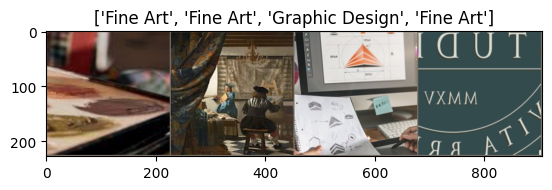

In [231]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])    

In [232]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [233]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [234]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



In [235]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



KeyboardInterrupt: 

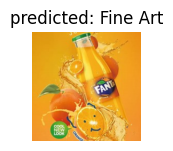

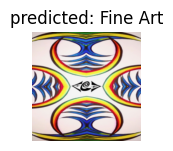

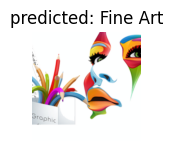

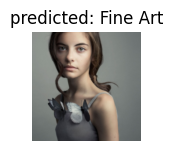

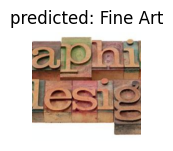

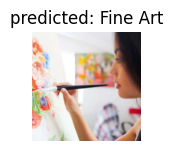

In [236]:
visualize_model(model_ft)